# Прогнозирование - это тоже регрессия! 

> 🚀 В этой практике нам понадобятся: `numpy==1.26.4, pandas==1.5.3, matplotlib==3.10.3, seaborn==0.13.2` 

> 🚀 Установить вы их можете с помощью команды: `%pip install numpy==1.26.4 pandas==1.5.3 matplotlib==3.10.3 seaborn==0.13.2` 


## Содержание

* [Загрузка исходных данных](#Загрузка-исходных-данных)
* [Анализ данных](#Анализ-данных)
  * [Временной диапазон](#Временной-диапазон)
  * [Дубликаты](#Дубликаты)
  * [Распределение данных по категориям](#Распределение-данных-по-категориям)
  * [Аномалии в целевой переменной](#Аномалии-в-целевой-переменной)
  * [Тренды](#Тренды)
  * [Пропуски в данных](#Пропуски-в-данных)
* [Заключение](#Заключение)
* [Вопросы для закрепления](#Вопросы-для-закрепления)


Привет! 

Регрессия в своём "сыром" виде редко встречается в задачах на практике, часто всё так или иначе упирается в задачу прогнозирования (forecasting). Прогнозирование от "сырой" регрессии отличается тем, что в данных всегда есть привязка ко времени. И в этом случае задача модели не просто предсказать какую-то непрерывную величину, а предсказать её с привязкой к конкретному временному промежутку. Другими словами, здесь разработчик делает модель-оракул, которая должна уметь предсказывать будущее. Вот и мы тоже попробуем сделать себе такого локального Нострадамуса 😊

Представим, что у нас есть крупная сеть пышечных, в которых продаются самые вкусные пышки в мире. Пышечные располагаются в разных странах, но везде есть одна и та же проблема: каждый день готовится одинаковое количество пышек с запасом, и в конце дня часть непроданных пышек приходится выкидывать. А это дополнительные расходы на ингредиенты, загрязнение окружающей среды и вообще истощение ресурсов. 

<p align="center"><img src="https://raw.githubusercontent.com/AleksDevEdu/ml_edu/master/assets/pushki.jpeg" width=600/></p>

Здесь в игру вступает модель Нострадамус, которая, опираясь на историю покупок в кафе и разные внешние факторы, может помочь нам и сказать, сколько пышек нужно приготовить, чтобы покупатели не остались без пышек, но и выбрасывать в конце дня нам пришлось по минимуму, в идеале вообще ничего не выбрасывать. В качестве признаков мы покажем модели историю покупок, информацию о месяце, дне недели, годе, праздниках, если есть информацию о погоде, мероприятиях и т.п. А в качестве целевой переменной будем ждать от модели ответ на вопрос "Сколько пышек нужно приготовить на завтра/послезавтра/на неделю вперёд и т.д." 

Для решения такой задачи есть (как минимум) два подхода: 
- статистические модели, 
- модели-регрессоры.

Далее мы посмотрим на эти подходы, но сначала, естественно, нам нужны данные и их анализ. 

In [78]:
import warnings

from datetime import date
from pathlib import Path 

import ipywidgets as widgets
from matplotlib import pyplot as plt
import seaborn as sns

import numpy as np 
import pandas as pd 

sns.set_style("darkgrid")
warnings.filterwarnings("ignore")

## Загрузка исходных данных

В папке [datasets](../datasets/) вы найдёте файл [ts_data.csv](../datasets/ts_data.csv). Это и будет наша отправная точка в мире пышек. 

Дальше, как и в предыдущих ноутбуках, нужно правильно положить данные в зависимости от того, где вы работаете: локально или в Google Colab. 

In [79]:
data_fpath = Path().cwd().parent / "datasets" / "ts_data.csv"
df = pd.read_csv(data_fpath, index_col=0)

df.head(5)

,id,date,country,store,product,num_sold
0,0,2010-01-01,Canada,Fluffy Bounce,Chocolate,NaN
1,1,2010-01-01,Canada,Fluffy Bounce,Cream,973.0
2,2,2010-01-01,Canada,Fluffy Bounce,Sugar Powder,906.0
3,3,2010-01-01,Canada,Fluffy Bounce,Coffee,423.0
4,4,2010-01-01,Canada,Fluffy Bounce,Strawberry Jam,491.0


Видно, что данные довольно минималистичные. Есть информация: 

- сколько (`num_sold`) и каких (`product`) пышек было продано,
- в какой день (`date`),
- в какой стране (`country`),
- в какой пышечной (`store`).

Прямо скажем - не густо. Но что есть, то есть. 

Сейчас из признаков есть только дата и страна, а целевая переменная - это количество пышек (`num_sold`), которые были проданы в этот день.

Перед началом основного анализа посмотрим на объём данных и типы колонок.

In [80]:
df.shape 

(230130, 6)

In [81]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 230130 entries, 0 to 230129
Data columns (total 6 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   id        230130 non-null  int64  
 1   date      230130 non-null  object 
 2   country   230130 non-null  object 
 3   store     230130 non-null  object 
 4   product   230130 non-null  object 
 5   num_sold  221259 non-null  float64
dtypes: float64(1), int64(1), object(4)
memory usage: 12.3+ MB


## Анализ данных 

### Временной диапазон 

Для удобства работы приведём колонку `date` к формату `datetime`.

<details>
    <summary>🤓 Что такое datetime формат? [Нажми на меня]</summary>

Формат `datetime` - это специальный формат для работы с датами и временем. Он позволяет хранить дату и время как **объект**, а не просто текст. Такой формат позволяет легко **сортировать** даты, производить с ними **арифметические** операции (сложение, вычитание и т.д.), производить **фильтрацию** и извлекать **части** (год, месяц, час, день). Такой формат сильно упрощает жизнь по сравнению с обработкой даты и времени в виде строки. 

</details>

In [82]:
df["date"] = pd.to_datetime(df["date"])

df.dtypes

id                   int64
date        datetime64[ns]
country             object
store               object
product             object
num_sold           float64
dtype: object

Тип колонки `date` с `object` изменился на `datetime64[ns]`. Это встроенный тип в `pandas`. Значит, конвертация прошла успешно. 

Раз уж коснулись специфики времени, давайте проверим, а какова частота данных. Как часто происходят продажи пышек? Каждую минуту, каждый час, каждый день, неделю, месяц и т.д.? 

Это важно понимать, т.к. зачастую, если привести данные к единому виду (к единой частоте), модель лучше обучится и даст более качественный результат. Процесс приведения временных рядов к единой частоте называется **ресемплингом**. 

<details>
    <summary>🤓 Что такое ресемплинг данных? [Нажми на меня]</summary>

**Ресемплинг данных** - это такая операция, которая помогает **"нормализовать"** данные под определённую **частоту**. Допустим, можно так преобразовать данные, чтобы каждая строка содержала информацию ровно за неделю, или за день, или за месяц (зависит от нужной частоты). Такой подход помогает модели получить дополнительную информацию для настройки обучения. 

</details>


Чтобы посчитать частоту, нужно всего лишь сравнить дельты в соседних строчках. Для этого можно использовать метод [`shift`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.shift.html)

In [83]:
# сделаем копию таблицы, чтобы не вносить изменения в исходные данные 
df_check = df.copy()
df_check["date_shifted"] = df_check["date"].shift()
df_check = df_check[~df_check["date_shifted"].isna()]

print(f"Максимальная частота: {(df_check['date'] - df_check['date_shifted']).max()}")

Максимальная частота: 1 days 00:00:00


Мы хотим, чтобы наша будущая модель предсказывала количество пышек для приготовления **в день**. И похоже нам сильно повезло, и делать ресемплинг не нужно, данные и так уже представлены с частотой 1 день. 

<details>
    <summary>🤓 Как понять, а какой ресемплинг делать? [Нажми на меня]</summary>

Это зависит от постановки задачи. Если бы мы хотели получить модель, предсказывающую сколько пышек надо приготовить в рамках месяца, то наши данные нужно было бы заресемплить к месячной частоте, чтобы каждая строка нашей таблицы содержала количество проданных пышек за определённый месяц. Другими словами, нужно было бы сложить все значения `num_sold` за определённый месяц. И вместо 31 строки получилась бы всего 1 с суммарным значением продаж. 

Здесь важно помнить, что чем выше частота, тем менее точными будут результаты, т.к. требования к работе модели будут расти. 
Например, всегда проще **в среднем** предсказать продажи за неделю/месяц, чем за каждый час или каждую минуту.

Хорошая новость в том, что в `pandas` уже есть готовый метод для ресемплинга [`resample`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.resample.html)

</details>

А теперь посмотрим за какое время у нас есть история продаж. 

In [84]:
df["date"].describe()

count                  230130
unique                   2557
top       2010-01-01 00:00:00
freq                       90
first     2010-01-01 00:00:00
last      2016-12-31 00:00:00
Name: date, dtype: object

Итак, видим, что: 

* данные представлены за 7 лет: с января 2010 по декабрь 2016;
* с частотой 1 день. 

> ⚠️ В прогнозировании важно обращать внимание на дату. Нужно помнить, что мы не можем заглянуть в будущее и дать модели признаки оттуда. Если данные перемешаются, то это приведёт к утечке информации, и модель будет бесполезна, потому что человек всё ещё не научился путешествовать во времени. 

### Дубликаты

Проверим есть ли дубликаты и пропуски в данных.

In [ ]:

dupl = df[df.duplicated(keep=False)]

dupl

assert np.allclose(dupl.shape, (0, 6)), "Ожидается, что дубликатов - нет. Проверьте свою функцию."

print("Тесты прошли! Всё хорошо!")



Тесты прошли! Всё хорошо!


In [86]:
assert np.allclose(dupl.shape, (0, 6)), "Ожидается, что дубликатов - нет. Проверьте свою функцию."

print("Тесты прошли! Всё хорошо!")

Тесты прошли! Всё хорошо!


Что ж, хорошая новость - дубликатов нет. Двигаемся дальше. 

### Распределение данных по категориям

Давайте посмотрим на наши пышечные более пристально. Для начала проверим в каких странах они расположены.

In [ ]:


countries = df['country'].value_counts()

countries

assert len(countries) == 6, f"Должно быть 6 стран, а у вас {len(countries)}"
assert np.allclose(np.unique(countries), [38355]), "Все страны должны иметь одинаковое кол-во пышек."

print("Тесты прошли! Всё хорошо!")

Тесты прошли! Всё хорошо!


In [88]:
assert len(countries) == 6, f"Должно быть 6 стран, а у вас {len(countries)}"
assert np.allclose(np.unique(countries), [38355]), "Все страны должны иметь одинаковое кол-во пышек."

print("Тесты прошли! Всё хорошо!")

Тесты прошли! Всё хорошо!


Сеть пышек международная с равномерным распределением продаж между странами. 

Идём дальше, а какие вообще есть пышечные в данных.

In [ ]:


stores = df['store'].value_counts()

stores

assert len(stores) == 3, f"Должно быть 3 вида пышечных, а у вас {len(stores)}"
assert np.allclose(np.unique(stores), [76710]), "Все пышечные должны иметь одинаковое кол-во пышек."

print("Тесты прошли! Всё хорошо!")

Тесты прошли! Всё хорошо!


In [90]:
assert len(stores) == 3, f"Должно быть 3 вида пышечных, а у вас {len(stores)}"
assert np.allclose(np.unique(stores), [76710]), "Все пышечные должны иметь одинаковое кол-во пышек."

print("Тесты прошли! Всё хорошо!")

Тесты прошли! Всё хорошо!


Видим, что у нас всего 3 вида разных пышечных, которые раскиданы по всему миру. 

* Fluffy Bounce 
* Donots
* Pyshka

Ну, и напоследок, давайте проверим какие типы пышек у нас продаются. 

In [ ]:


products = df['product'].value_counts()

products

assert len(products) == 5, f"Должно быть 5 видов пышек, а у вас {len(products)}"
assert np.allclose(np.unique(products), [46026]), "В данных должно быть одинаковое кол-во каждого вида пышек."

print("Тесты прошли! Всё хорошо!")

Тесты прошли! Всё хорошо!


In [92]:
assert len(products) == 5, f"Должно быть 5 видов пышек, а у вас {len(products)}"
assert np.allclose(np.unique(products), [46026]), "В данных должно быть одинаковое кол-во каждого вида пышек."

print("Тесты прошли! Всё хорошо!")

Тесты прошли! Всё хорошо!


Что мы нашли в данных:

1. Пышечные располагаются в 6 странах: 
   1. Canada (Канада),
   2. Finland (Финляндия),
   3. Italy (Италия),
   4. Kenya (Кения),
   5. Norway (Норвегия),
   6. Singapore (Сингапур).
2. Всего есть 3 типа пышечных: `Fluffy Bounce`, `Donots` и `Pyshka`.
3. Всего есть 5 типов пышек:
   1. `Chocolate` (Шоколадные),
   2. `Cream` (С кремом),
   3. `Sugar Powder` (С сахарной пудрой),
   4. `Coffee` (Кофейные),
   5. `Strawberry Jam` (С клубничным вареньем).

Из распределений пока чего-то интересного не видно. Информация распределена равномерно, даже как-то не хватает динамики. 

Для упрощения восприятия очень помогают графики, в них сразу вылезают нюансы. 

Для наглядности отрисуем данные по всем странам на одном графике. На нашем графике будет информация об относительном количестве проданных пышек за день по странам.

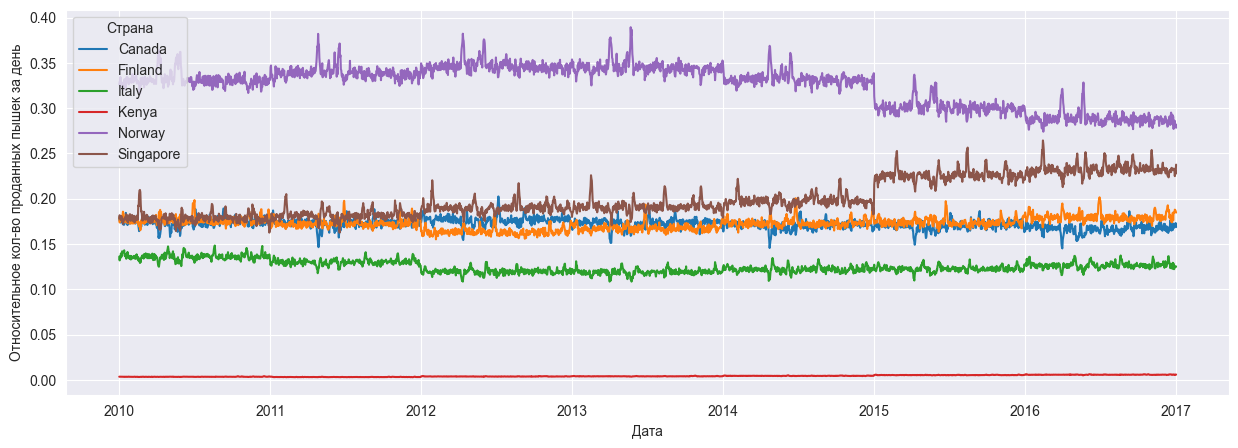

In [93]:
# Cумма проданных пышек за день по всем странам
sold_by_date = df.groupby("date")["num_sold"].sum()

# Относительная сумма проданных пышек за день в каждой стране относительно общего кол-ва пышек за день 
country_ratio_over_time = df.groupby(["date", "country"])["num_sold"].sum() / sold_by_date
country_ratio_over_time = country_ratio_over_time.reset_index()

fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(15, 5))
sns.lineplot(data=country_ratio_over_time, x="date", y="num_sold", hue="country")

plt.legend(title="Страна")
plt.ylabel("Относительное кол-во проданных пышек за день")
plt.xlabel("Дата")
plt.show()

Из этого графика сразу видно, что рекордсменом по проданным пышкам является Норвегия. А меньше всего любят пышки в Кении. 

Однако в 2015 году что-то произошло, что привело к уменьшению продаж пышек в Норвегии и увеличению продаж в Сингапуре. 

А также, если приглядеться, то можно заметить, что в 2012 году тоже было что-то странное, что немного пошатнуло стабильность продаж в Италии и Финляндии. 


Давайте зайдём с другой стороны и сделаем небольшой виджет, чтобы посмотреть, как во времени изменяются объёмы продаж пышек в каждой стране.

In [94]:
@widgets.interact(
    country=widgets.Dropdown(options=df["country"].unique()),
    start_date=widgets.DatePicker(value=df["date"].min()),
)
def show_country_data(country: str, start_date):
    start_date = pd.Timestamp(start_date)
    plot_df = df[(df["country"] == country) & (df["date"].dt.date >= start_date.date())]

    fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(15, 4))

    axs.plot(plot_df["date"], plot_df["num_sold"])
    axs.set_xlabel("Дата")
    axs.set_ylabel("Кол-во проданных пышек")

    plt.show()

interactive(children=(Dropdown(description='country', options=('Canada', 'Finland', 'Italy', 'Kenya', 'Norway'…

Посмотрите, как меняется картинка в зависимости от выбора страны. 

> 🤓 Если изменить `start_date`, то можно рассмотреть временной ряд поближе.

В целом графики довольно "шумные" и каких-то важных деталей здесь мы не получим. Но сразу бросается в глаза, что уровень продаж сильно отличается между некоторыми странами. 

Например, в Норвегии в среднем продают по `2500` пышек, а в Кении около `30`. Что в целом можно объяснить политической и экономической ситуациями в этих странах. 

Но также можно заметить, что в Кении с каждым годом продают всё больше и больше пышек.

Теперь ещё больше усилим гранулярность и посмотрим, а как выглядит временной ряд, если смотреть сразу в рамках определённой пышечной в одной стране.

<details>
    <summary>🤓 Что такое гранулярность данных? [Нажми на меня]</summary>

**Гранулярность данных** – это уровень детализации информации в данных. Чем выше гранулярность, тем больше деталей, но тем сложнее работать с данными.

Представьте, что вы смотрите на карту города:
- Если смотреть на весь город в целом, это грубая гранулярность (низкая детализация).
- Если видно каждую улицу и здание, это высокая гранулярность (много деталей).

</details>

In [95]:
@widgets.interact(
    country=widgets.Dropdown(options=df["country"].unique()),
    store=widgets.Dropdown(options=df["store"].unique()),
    start_date=widgets.DatePicker(value=df["date"].min()),
)
def show_country_store_data(country: str, store: str, start_date: date): 
    start_date = pd.Timestamp(start_date)
    plot_df = df[
        (df["country"] == country)
        & (df["store"] == store)
        & (df["date"].dt.date >= start_date.date())
    ]

    fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(15, 4))

    axs.plot(plot_df["date"], plot_df["num_sold"])
    axs.set_xlabel("Дата")
    axs.set_ylabel("Кол-во проданных пышек")

    plt.show()

interactive(children=(Dropdown(description='country', options=('Canada', 'Finland', 'Italy', 'Kenya', 'Norway'…

Цифры по оси `у` изменились, что ожидаемо. Но форма данных осталась примерно такой же как мы видели ранее. 

Также можно заметить, что некоторые пышечные в рамках одной страны, более успешны, чем другие. Например, дела у `Fluffy Bounce` в Канаде идут хуже, чем у `Donots` и `Pyshka`. В среднем она продаёт около 500 пышек, при этом другие пышечные продают в 2-3 раза больше. 

Давайте теперь ещё добавим тип пышки, чтобы совсем уж по красоте смотреть.

In [96]:
@widgets.interact(
    country=widgets.Dropdown(options=df["country"].unique()),
    store=widgets.Dropdown(options=df["store"].unique()),
    products=widgets.Dropdown(options=df["product"].unique()),
    start_date=widgets.DatePicker(value=df["date"].min()),
)
def show_country_store_product_data(country: str, store: str, products: str, start_date: date): 
    start_date = pd.Timestamp(start_date)
    plot_df = df[
        (df["country"] == country)
        & (df["store"] == store)
        & (df["product"] == products)
        & (df["date"].dt.date >= start_date.date())
    ]

    fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(15, 4))

    axs.plot(plot_df["date"], plot_df["num_sold"])
    axs.set_xlabel("Дата")
    axs.set_ylabel("Кол-во проданных пышек")

    plt.show()

interactive(children=(Dropdown(description='country', options=('Canada', 'Finland', 'Italy', 'Kenya', 'Norway'…

Так, а вот тут начинаются взрослые интересности. Можно видеть, что в некоторых странах для определённых пышек в определённых пышечных вообще нет временных рядов. Например, в Канаде в пышечной `Fluffy Bounce` совсем не продают шоколадные пышки. 

Также бросается в глаза разная форма графиков. Например, в Кении в `Fluffy Bounce` пышки с клубничным вареньем набирают обороты во времени. При этом в Канаде интерес к ним ослабевает. 

### Аномалии в целевой переменной

Давайте смотреть статистику по целевой переменной (`num_sold`) более пристально.

Для начала выведем общую информацию: среднее значение, стандартное отклонение, персентили и т.п.

In [ ]:

stat = df['num_sold'].describe()

stat

assert len(stat) == 8, "Выведены не все статистики, должно быть 8 штук"
print("Тесты прошли! Всё хорошо!")

Тесты прошли! Всё хорошо!


In [98]:
assert len(stat) == 8, "Выведены не все статистики, должно быть 8 штук"

print("Тесты прошли! Всё хорошо!")

Тесты прошли! Всё хорошо!


Сразу видно как сильно значения в переменной "шатаются". Т.е. разброс значений от 5 до 6000, не слабо так. Да ещё и std составляет почти 700 пышек 🤔

Но как мы убедились ранее, смотреть на данные "в целом" не даёт особо профита. Давайте смотреть точечно по каждой пышке в каждой пышечной по отдельности.

In [99]:
@widgets.interact(
    country=widgets.Dropdown(options=df["country"].unique()),
    store=widgets.Dropdown(options=df["store"].unique()),
    products=widgets.Dropdown(options=df["product"].unique()),
)
def show_target_statistics(country: str, store: str, products: str):  # noqa: D103
    plot_df = df[(df["country"] == country) & (df["store"] == store) & (df["product"] == products)]

    na_val = plot_df["num_sold"].isna().sum()
    print(f"Кол-во пропущенных значений: {na_val} ({na_val / len(plot_df) * 100:.1f}%)")  # noqa: T201

    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))

    sns.histplot(
        plot_df,
        x="num_sold",
        kde=True,
        bins=30,
        log_scale=False,
        ax=axs[0],
    )
    axs[0].set_xlabel("Кол-во проданных пышек")
    axs[0].set_ylabel("Плотность распределения")
    axs[0].set_title("Распределение кол-ва проданных пышек")

    if na_val != len(plot_df):
        sns.boxplot(plot_df["num_sold"], ax=axs[1])
    axs[1].set_title("Ящик с усами: Кол-во проданных пышек")

    plt.tight_layout()
    plt.show()

interactive(children=(Dropdown(description='country', options=('Canada', 'Finland', 'Italy', 'Kenya', 'Norway'…

Пощёлкав графики можно заметить, что в основной массе продажи пышек имеют нормальное распределение (как и многое в нашей жизни). 

> 🤓 Если кто забыл какие бывают распределения, то загляните [сюда](https://github.com/serykhelena/data-science-resources/blob/develop/guides/DATA-DISTRIBUTIONS.md).

Но, что более интересно, ящик с усами почти для всех пышек показывает наличие выбросов (аномалий). 

<details>
    <summary>🤓 Что такое выбросы (аномалии) в данных? [Нажми на меня]</summary>

**Выбросы** – это значения, которые сильно отличаются от остальных данных. Они выглядят как «ошибки» или «нестандартные» точки в наборе данных.

Представьте, что в вашей группе за тест все получили от 5 до 10 баллов. Но при этом один человек почему-то набрал *1000 баллов*. Вот он и будет выбросом в данных в этом случае.   

</details>

Аномалии в данных также лучше в дальнейшем обработать, чтобы сделать жизнь модели чуть легче. Ей и так нелегко. 

Для более общей картины можно вывести ящики с усами для данных по странам и по пышечным, чтобы хотя бы индикативно понять, где больше всего проблем с выбросами.

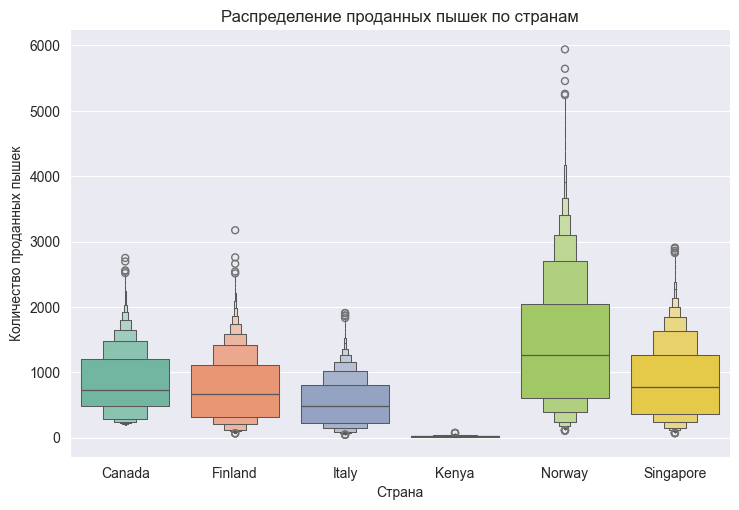

In [100]:
sns.catplot(
    data=df,
    x="country",
    y="num_sold",
    kind="boxen",
    aspect=1.5,
    palette="Set2",
)

plt.xlabel("Страна")
plt.ylabel("Количество проданных пышек")
plt.title("Распределение проданных пышек по странам")

plt.show()

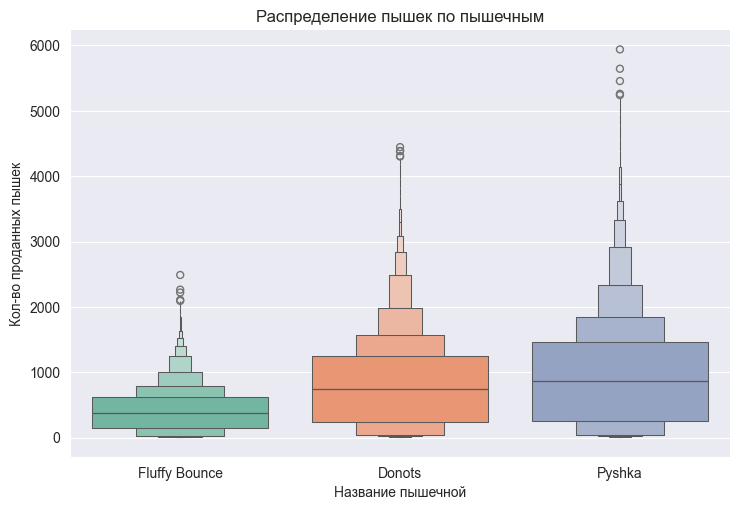

In [101]:
sns.catplot(
    data=df,
    x="store",
    y="num_sold",
    kind="boxen",
    aspect=1.5,
    palette="Set2",
)

plt.xlabel("Название пышечной")
plt.ylabel("Кол-во проданных пышек")
plt.title("Распределение пышек по пышечным")

plt.show()

В целом каких-то криминальных тенденций в какой-то одной стране или в какой-то одной пышечной особо не заметно. 

Бросается в глаза, что в Норвегии и Финляндии разброс между аномальными значеними больше, чем в других странах. Видимо, есть что-то особенное в скандинавских странах. 

### Тренды

А теперь давайте посмотрим на тренды в данных. 


<details>
    <summary>🤓 Что такое тренды во временных рядах? [Нажми на меня]</summary>

**Тренды** при работе с временными рядами — это общее направление, в котором изменяются значения данных во времени. Проще говоря, тренд показывает, как данные меняются в долгосрочной перспективе, игнорируя краткосрочные колебания.

По направлению тренды бывают: 
- восходящими: значения постепенно увеличиваются со временем; 
- нисходящими: значения постепенно уменьшаются; 
- боковыми: нет выраженного изменения, значения остаются на одном уровне.

А по форме: 
- линейные: прямолинейное изменение данных;
- нелинейные: сложные формы, например, экспоненциальный или полиномиальный рост.

При анализе тренд помогает выделить сезонность или аномалии в данных. 

Например, всем известно, что в России арбузы покупают преимущественно в конце лета, а мандарины - зимой. Это сезонность. 

При этом если собрать статистику по покупке смартфонов, то увидим **восходящий** тренд. Смартфоны с каждым годом покупают всё больше и больше людей. 

Такая информация может помочь как человеку при подготовке данных, так и модели при предсказании / прогнозировании. 

</details>

Давайте сгруппируем данные по неделям и посмотрим, есть ли там какие-либо заметные тренды

In [102]:
# группировка по неделям 
weekly_df = df.groupby(["country", "store", "product", pd.Grouper(key="date", freq="W")])
weekly_df = weekly_df["num_sold"].sum().rename("num_sold").reset_index()

@widgets.interact(
    store=widgets.Dropdown(options=weekly_df["store"].unique()),
    product=widgets.Dropdown(options=weekly_df["product"].unique()),
)
def show_product_weekly_trend(store: str, product: str):
    plot_df = weekly_df[(weekly_df["product"] == product) & (weekly_df["store"] == store)]

    _fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(15, 4))
    sns.lineplot(data=plot_df, x="date", y="num_sold", hue="country", ax=axs)
    plt.xlabel("Дата")
    plt.ylabel("Кол-во проданных пышек")
    plt.title("Группировка по неделям")
    plt.show()

interactive(children=(Dropdown(description='store', options=('Donots', 'Fluffy Bounce', 'Pyshka'), value='Dono…

Сразу выделяется сезонность для некоторых видов пышек. 

Например, в `Donots` в Канаде потребление шоколадных пышек снижается в середине года (летом), а ближе к зиме люди покупают пышек больше.

Также можно видеть нисходящий тренд для пышек с клубничным вареньем почти во всех странах, кроме Италии и Канады.

### Пропуски в данных

И, наконец, давайте посмотрим на пропущенные значения в данных. 

На графиках мы уже видели, что они есть. Давайте оценим масштаб трагедии. 

In [ ]:


null_df = df.isnull().sum()

null_df

assert len(null_df) == 6, "Нужно вывести инфу по всем колонкам"
assert np.isclose(null_df["num_sold"], 8871), "Нужно вывести абсолютное количество пропущенных значений"

print("Тесты прошли! Всё хорошо!")

Тесты прошли! Всё хорошо!


In [104]:
assert len(null_df) == 6, "Нужно вывести инфу по всем колонкам"
assert np.isclose(null_df["num_sold"], 8871), "Нужно вывести абсолютное количество пропущенных значений"

print("Тесты прошли! Всё хорошо!")

Тесты прошли! Всё хорошо!


In [ ]:


null_df = df.isnull().sum() / len(df) * 100

null_df

assert len(null_df) == 6, "Нужно вывести инфу по всем колонкам"
assert np.isclose(null_df["num_sold"], 3.85, atol=1e-2), "Нужно вывести относительное (в %) количество пропущенных значений"

print("Тесты прошли! Всё хорошо!")

Тесты прошли! Всё хорошо!


In [106]:
assert len(null_df) == 6, "Нужно вывести инфу по всем колонкам"
assert np.isclose(null_df["num_sold"], 3.85, atol=1e-2), "Нужно вывести относительное (в %) количество пропущенных значений"

print("Тесты прошли! Всё хорошо!")

Тесты прошли! Всё хорошо!


Пум-пум... Видим, что в целевой переменной пропущено около 4% данных. 
Это уже не сюрпиз, но всё равно не приятно. 

> ⚠️ Запомним, вернёмся к этой проблеме, когда будем делать предобработку данных.

Давайте для наглядности отрисуем графики, где красными вертикальными линиями будут показаны дни, где у нас не хватает информации о проданных пышках.

In [107]:
@widgets.interact(
    country=widgets.Dropdown(options=df["country"].unique()),
    store=widgets.Dropdown(options=df["store"].unique()),
    product=widgets.Dropdown(options=df["product"].unique()),
)
def show_missing_target(country: str, store: str, product: str):
    plot_df = df[
        (df["country"] == country)
        & (df["store"] == store)
        & (df["product"] == product)
    ]
    sample_missing_vals = plot_df.loc[plot_df["num_sold"].isna()]
    print(f"Кол-во пропущенных значений: {len(sample_missing_vals)} ({len(sample_missing_vals) / len(plot_df) * 100:.2f}%)")
 
    fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(15, 4))

    sns.lineplot(data=plot_df, x="date", y="num_sold", ax=axs)
    for missing_date in sample_missing_vals["date"]:
        axs.axvline(missing_date, color="red", linestyle="-", linewidth=1, alpha=0.2)

    plt.show()

interactive(children=(Dropdown(description='country', options=('Canada', 'Finland', 'Italy', 'Kenya', 'Norway'…

Прощёлкав графики можно заметить, что есть группы, где **все** значения целевой переменной пропущены. Тут встаёт резонный вопрос: "Что делать?". 

Есть разные варианты, но так как сейчас мы занимаемся только анализом, давайте ещё чуть плотнее пощупаем данные именно для таких случаев.

Для начала сформируем дополнительную колонку и назовём её `segment` - это комбинация страны, пышечной и типа пышки. Таким образом мы узнаем, сколько всего у нас уникальных групп.  

In [108]:
# сделаем копию нашей таблицы, чтобы не менять исходные данные
df_check = df.copy()
df_check["segment"] = df_check["country"] + "_" + df_check["store"] + "_" + df_check["product"]
df_check["segment"].nunique()

90

Всего у нас 90 групп. Что сходится с тем, если перемножить все комбинации: 5 стран * 3 пышечные * 6 типов пышек = 90

Давайте посмотрим, а сколько у нас групп, где пропущено хотя бы одно значение.

In [109]:
data_with_null = df_check["num_sold"].isnull().groupby(df_check["segment"]).sum().reset_index(name='null_count')

data_with_null[data_with_null["null_count"] > 0]

,segment,null_count
0,Canada_Donots_Chocolate,1308
5,Canada_Fluffy Bounce_Chocolate,2557
6,Canada_Fluffy Bounce_Coffee,1
10,Canada_Pyshka_Chocolate,380
45,Kenya_Donots_Chocolate,1358
50,Kenya_Fluffy Bounce_Chocolate,2557
51,Kenya_Fluffy Bounce_Coffee,63
53,Kenya_Fluffy Bounce_Strawberry Jam,1
55,Kenya_Pyshka_Chocolate,646


Итак, видим, что всего у нас 9 групп, где есть хотя бы одно пропущенное значение. 

Чаще всего пропуски встречаются в данных с шоколажными пышками в 2-х странах, в Канаде и Кении.

Теперь давайте оставим только те группы, где полностью пропущены все значения.

In [110]:
# сгруппируем данные по сегменту и посчитаем среднее значение продаж 
# ожидаемо, что для полностью пропущенного ряда, среднее значение будет равно None 
df_grouped = df_check.groupby(["segment"], as_index=False)["num_sold"].mean()

# оставим только те группы, где среднее значение продаж = None 
empty_segments = df_grouped[df_grouped["num_sold"].isna()]

# для удобства работы разделим сегмент обратно на отдельные колонки: страна, пышечная, тип пышки 
empty_segments["country"] = empty_segments["segment"].apply(lambda x: x.split("_")[0])
empty_segments["store"] = empty_segments["segment"].apply(lambda x: x.split("_")[1])
empty_segments["product"] = empty_segments["segment"].apply(lambda x: x.split("_")[2])

empty_segments

,segment,num_sold,country,store,product
5,Canada_Fluffy Bounce_Chocolate,NaN,Canada,Fluffy Bounce,Chocolate
50,Kenya_Fluffy Bounce_Chocolate,NaN,Kenya,Fluffy Bounce,Chocolate


И мы видим, что у нас есть 2 пышечные с полностью пропущенными значениями. 

Интересно, что это одна и та же пышечная `Fluffy Bounce`, которая отказывается продавать шоколадные пышки в Канаде и Кении 🤔

Ради любопытства давайте посмотрим, как выглядят продажи шоколадных пышек в этой сети пышечных в других странах. 
Виджет в студию! 

In [111]:
@widgets.interact(
    country=widgets.Dropdown(options=df["country"].unique()),
    store=widgets.Dropdown(options=empty_segments["store"].unique()),
    products=widgets.Dropdown(options=empty_segments["product"].unique()),
)
def show_empty_similar_data(country: str, store: str, products: str):
    plot_df = df[
        (df["country"] == country)
        & (df["store"] == store)
        & (df["product"] == products)
    ]

    fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(15, 4))

    axs.plot(plot_df["date"], plot_df["num_sold"])
    axs.set_xlabel("Date")
    axs.set_ylabel("Number of sold stickers")

    plt.show()

interactive(children=(Dropdown(description='country', options=('Canada', 'Finland', 'Italy', 'Kenya', 'Norway'…

Так-так-так... Кажется, у них есть что-то общее ... 🤔 Но это уже в следующей части.

## Заключение

В этом ноутбуке вы узнали, что: 
- есть "специальная" регрессия, которая используется в прогнозировании (aka предсказание будущего);
- в прогнозировании решающую роль играет работа со временем (поэтому этот раздел и назван `timeseries`);
- можно построить разные графики, чтобы узнать о неожиданных скелетах в шкафах у данных.

Конечно, это только базовые подходы. Всё всегда исходит из данных: как результаты, так и сложности. 
А анализ данных - это вообще бесконечный и творческий процесс.

Далее мы посмотрим, а что делать со всем тем, что мы нашли в данных. И какие модели помогут нам в действительности предсказывать будущее. 

## Вопросы для закрепления

1. В чём особенности решения задачи прогнозирования? 
2. Что такое ресемплинг данных? Какие есть преимущества и недостатки у этого подхода? 
3. Что такое тренды в данных? 
4. Нужно ли сортировать данные в прогнозировании? Если нужно, то как именно? 
5. Какую задачу получится решить более простыми средствами: прогнозирование на день или прогнозирование на 3 дня?  